# Sensor Data Analysis

Analyse "Bag of sensors" data from PhysioNet: https://physionet.org/physiobank/database/noneeg/

Under/Oversampling

Feature Extraction
- Statistical
- Spectral

Modeling

## Data Introduction

## Load Data

Each subject has several datafiles:
- SubjectN_AccTempEDA.atr: annotation
- SubjectN_AccTempEDA.dat: data
- SubjectN_AccTempEDA.hea: header
- SubjectN_Sp02HR.dat: data
- SubjectN_Sp02HR.hea: header

These files are in the WFDB (WaveForm DataBase) format, and can be read using the `wfdb` python module.
(https://github.com/MIT-LCP/wfdb-python)

https://www.physionet.org/standards/npsg/Moody.pdf

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

plt.style.use('seaborn-white')

# pip install wfdb
import wfdb

# render plots inline
%matplotlib inline

### Acc Temp EDA

In [2]:
ann = wfdb.rdann('./data/physionet/Subject10_AccTempEDA', extension='atr', summarize_labels=True)
print(ann.__dict__)

{'record_name': 'Subject10_AccTempEDA', 'extension': 'atr', 'sample': array([    1,  2401,  5010,  7411,  7732, 10573, 12974, 15839]), 'symbol': ['"', '"', '"', '"', '"', '"', '"', '"'], 'subtype': array([0, 0, 0, 0, 0, 0, 0, 0]), 'chan': array([0, 0, 0, 0, 0, 0, 0, 0]), 'num': array([0, 0, 0, 0, 0, 0, 0, 0]), 'aux_note': ['Relax', 'PhysicalStress', 'Relax', 'EmotionalStress', 'CognitiveStress', 'Relax', 'EmotionalStress', 'Relax'], 'fs': 8, 'label_store': None, 'description': None, 'custom_labels': None, 'contained_labels':     label_store symbol         description
22           22      "  Comment annotation, 'ann_len': 8}


{'record_name': 'Subject10_AccTempEDA', 'n_sig': 5, 'fs': 8, 'counter_freq': None, 'base_counter': None, 'sig_len': 18239, 'base_time': None, 'base_date': None, 'comments': ['age: 23', 'gender: M', 'height/cm: 180', 'weight/kg: 64'], 'sig_name': ['ax', 'ay', 'az', 'temp', 'EDA'], 'p_signal': array([[ 4.49967956e-01, -1.00996857e+00, -4.00036622e-02,
         2.70000641e+01,  3.25101413e+00],
       [ 4.39992676e-01, -1.01998718e+00, -4.00036622e-02,
         2.70000641e+01,  3.25605237e+00],
       [ 4.49967956e-01, -1.01998718e+00, -5.00045778e-02,
         2.70000641e+01,  3.25605237e+00],
       ...,
       [ 8.79985351e-01, -7.49980163e-01, -2.00018311e-02,
         3.34999664e+01,  6.22591473e+00],
       [ 8.79985351e-01, -7.49980163e-01, -2.00018311e-02,
         3.34999664e+01,  6.22591473e+00],
       [ 8.79985351e-01, -7.49980163e-01, -2.00018311e-02,
         3.34999664e+01,  6.22591473e+00]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['Subject1

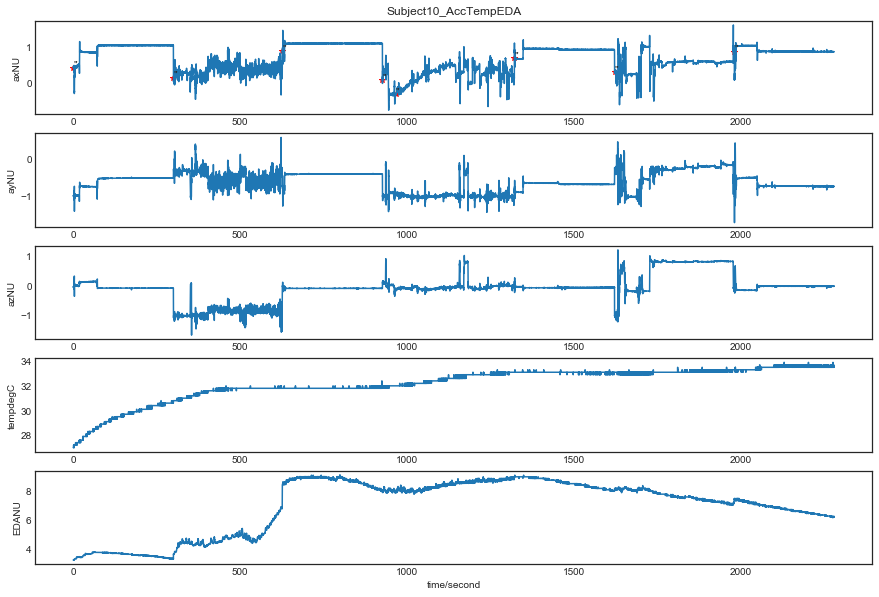

In [3]:
record_acc_temp_eda = wfdb.rdrecord('./data/physionet/Subject10_AccTempEDA')
print(record_acc_temp_eda.__dict__)

wfdb.plot_wfdb(record=record_acc_temp_eda, title='Subject10_AccTempEDA', annotation=ann, plot_sym=True, 
               time_units='seconds', figsize=(15, 10))

In [4]:
data_acc_temp_eda = record_acc_temp_eda.p_signal
data_acc_temp_eda.shape

(18239, 5)

### SpO2 HR

{'record_name': 'Subject10_SpO2HR', 'n_sig': 2, 'fs': 1, 'counter_freq': None, 'base_counter': None, 'sig_len': 2286, 'base_time': None, 'base_date': None, 'comments': ['age: 23', 'gender: M', 'height/cm: 180', 'weight/kg: 64'], 'sig_name': ['SpO2', 'hr'], 'p_signal': array([[96.99995422, 95.99990844],
       [95.99993896, 95.99990844],
       [95.99993896, 96.9999237 ],
       ...,
       [95.99993896, 69.00027467],
       [95.99993896, 68.00025941],
       [95.99993896, 67.00024415]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['Subject10_SpO2HR.dat', 'Subject10_SpO2HR.dat'], 'fmt': ['16', '16'], 'samps_per_frame': [1, 1], 'skew': [None, None], 'byte_offset': [None, None], 'adc_gain': [13106.8, 1284.98039216], 'baseline': [-1251699, -112435], 'units': ['%', 'bpm'], 'adc_res': [16, 16], 'adc_zero': [0, 0], 'init_value': [19660, 10923], 'checksum': [39424, 34156], 'block_size': [0, 0]}


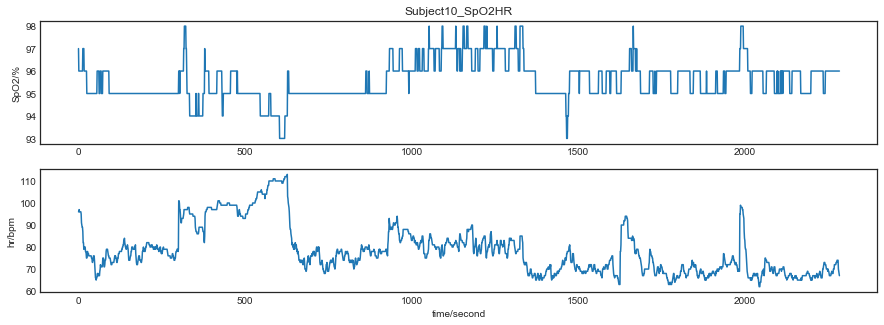

In [5]:
record_spo2_hr = wfdb.rdrecord('./data/physionet/Subject10_SpO2HR')
print(record_spo2_hr.__dict__)

wfdb.plot_wfdb(record=record_spo2_hr, title='Subject10_SpO2HR', time_units='seconds', figsize=(15, 5))

In [6]:
data_spo2_hr = record_spo2_hr.p_signal
data_spo2_hr.shape

(2286, 2)

In [7]:
# number of acceleration, etc samples per second
record_acc_temp_eda.fs

8

In [8]:
# number of SpO2 and HR samples per second
record_spo2_hr.fs

1

## Aligning data of different frequencies

The two dataset frequencies (number of samples per second) are different.

To support processing both datasets at the same time, we need to match the frequencies.

This is a common situation when taking readings from different sensors or data sources.

Two strategies:
1. Upsampling the smaller frequency data. E.g: repeat samples or interpolate.
2. Downsampling the larger frequency data. E.g: replace with mean or median.

Which one to pick depends on requirements: whether you need to maintain precision of the higher frequency dataset.

Example: https://machinelearningmastery.com/resample-interpolate-time-series-data-python/

### Option 1: Upsampling SpO2 HR to 8 samples per second

In [9]:
# create an index with 1 second timestamps, using the length of data_spo2_hr
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.period_range.html
#
# frequency strings: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

# for this dataset, the start date is just an arbitrary reference
per_second_index = pd.period_range(start='2019-01-01', periods=len(data_spo2_hr), freq='S')
per_second_index

PeriodIndex(['2019-01-01 00:00:00', '2019-01-01 00:00:01',
             '2019-01-01 00:00:02', '2019-01-01 00:00:03',
             '2019-01-01 00:00:04', '2019-01-01 00:00:05',
             '2019-01-01 00:00:06', '2019-01-01 00:00:07',
             '2019-01-01 00:00:08', '2019-01-01 00:00:09',
             ...
             '2019-01-01 00:37:56', '2019-01-01 00:37:57',
             '2019-01-01 00:37:58', '2019-01-01 00:37:59',
             '2019-01-01 00:38:00', '2019-01-01 00:38:01',
             '2019-01-01 00:38:02', '2019-01-01 00:38:03',
             '2019-01-01 00:38:04', '2019-01-01 00:38:05'],
            dtype='period[S]', length=2286, freq='S')

In [10]:
# create a dataframe for SpO2 data using the above period index
df_spO2_hr = pd.DataFrame(data_spo2_hr, index=per_second_index, columns=record_spo2_hr.sig_name)
df_spO2_hr.head()

,SpO2,hr
2019-01-01 00:00:00,96.999954,95.999908
2019-01-01 00:00:01,95.999939,95.999908
2019-01-01 00:00:02,95.999939,96.999924
2019-01-01 00:00:03,95.999939,95.999908
2019-01-01 00:00:04,95.999939,95.999908


In [11]:
# upsample to match the frequency of the other data (8 times)

In [12]:
factor = record_acc_temp_eda.fs / record_spo2_hr.fs
factor

8.0

In [13]:
# resample, then interpolate
# Note: whether interpolation makes sense depends on the sensor and type of data
upsampled = df_spO2_hr.resample('125ms')

df_upsampled = upsampled.interpolate()
df_upsampled.head(10)

,SpO2,hr
2019-01-01 00:00:00.000,96.999954,95.999908
2019-01-01 00:00:00.125,96.874952,95.999908
2019-01-01 00:00:00.250,96.749950,95.999908
2019-01-01 00:00:00.375,96.624949,95.999908
2019-01-01 00:00:00.500,96.499947,95.999908
2019-01-01 00:00:00.625,96.374945,95.999908
2019-01-01 00:00:00.750,96.249943,95.999908
2019-01-01 00:00:00.875,96.124941,95.999908
2019-01-01 00:00:01.000,95.999939,95.999908
2019-01-01 00:00:01.125,95.999939,96.124910


In [14]:
df_upsampled.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 18288 entries, 2019-01-01 00:00:00.000 to 2019-01-01 00:38:05.875
Freq: 125L
Data columns (total 2 columns):
SpO2    18288 non-null float64
hr      18288 non-null float64
dtypes: float64(2)
memory usage: 428.6 KB


In [15]:
# Note: there are fewer values in the Acc dataframe, so we need to ignore the
# later entries from df_upsampled.

df_acc_temp_eda = pd.DataFrame(data_acc_temp_eda, columns=record_acc_temp_eda.sig_name)
df_acc_temp_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18239 entries, 0 to 18238
Data columns (total 5 columns):
ax      18239 non-null float64
ay      18239 non-null float64
az      18239 non-null float64
temp    18239 non-null float64
EDA     18239 non-null float64
dtypes: float64(5)
memory usage: 712.5 KB


In [16]:
df_acc_temp_eda.index = df_upsampled.index[:len(df_acc_temp_eda)]
df_acc_temp_eda.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 18239 entries, 2019-01-01 00:00:00.000 to 2019-01-01 00:37:59.750
Freq: 125L
Data columns (total 5 columns):
ax      18239 non-null float64
ay      18239 non-null float64
az      18239 non-null float64
temp    18239 non-null float64
EDA     18239 non-null float64
dtypes: float64(5)
memory usage: 855.0 KB


In [17]:
# concatenate the two dataframes, column-wise
df_option1 = pd.concat([df_acc_temp_eda, df_upsampled], axis=1).dropna()
df_option1.head()

,ax,ay,az,temp,EDA,SpO2,hr
2019-01-01 00:00:00.000,0.449968,-1.009969,-0.040004,27.000064,3.251014,96.999954,95.999908
2019-01-01 00:00:00.125,0.439993,-1.019987,-0.040004,27.000064,3.256052,96.874952,95.999908
2019-01-01 00:00:00.250,0.449968,-1.019987,-0.050005,27.000064,3.256052,96.749950,95.999908
2019-01-01 00:00:00.375,0.449968,-1.009969,-0.040004,27.000064,3.256052,96.624949,95.999908
2019-01-01 00:00:00.500,0.439993,-1.009969,-0.050005,27.000064,3.256052,96.499947,95.999908


In [18]:
df_option1.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 18239 entries, 2019-01-01 00:00:00.000 to 2019-01-01 00:37:59.750
Freq: 125L
Data columns (total 7 columns):
ax      18239 non-null float64
ay      18239 non-null float64
az      18239 non-null float64
temp    18239 non-null float64
EDA     18239 non-null float64
SpO2    18239 non-null float64
hr      18239 non-null float64
dtypes: float64(7)
memory usage: 1.1 MB


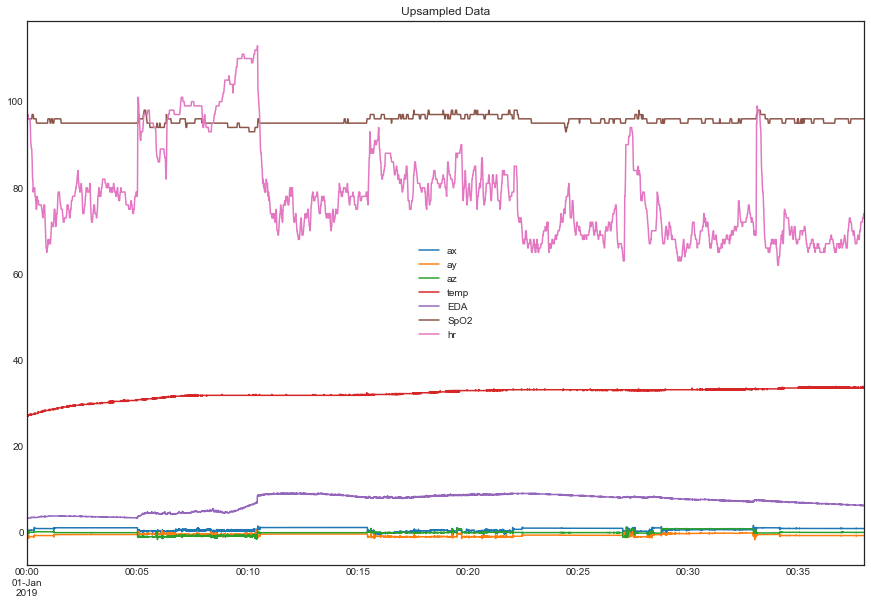

In [19]:
# https://stackoverflow.com/questions/48126330/python-int-too-large-to-convert-to-c-long-plotting-pandas-dates
df_option1.index = pd.to_datetime(df_option1.index.to_timestamp())

df_option1.plot(figsize=(15, 10))
ax = plt.gca()
ax.set_title('Upsampled Data')
plt.show()

In [20]:
df_option1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18239 entries, 2019-01-01 00:00:00 to 2019-01-01 00:37:59.750000
Freq: 125L
Data columns (total 7 columns):
ax      18239 non-null float64
ay      18239 non-null float64
az      18239 non-null float64
temp    18239 non-null float64
EDA     18239 non-null float64
SpO2    18239 non-null float64
hr      18239 non-null float64
dtypes: float64(7)
memory usage: 1.1 MB


### Option 2: Downsampling Acc Temp EDA to 1 sample per second

In [21]:
# create an index with 125 millisecond timestamps, using the length of data_acc_temp_eda
#
# frequency strings: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

# for this dataset, the start date is just an arbitrary reference
per_125_ms_index = pd.period_range(start='2019-01-01', periods=len(data_acc_temp_eda), freq='125ms')
per_125_ms_index

PeriodIndex(['2019-01-01 00:00:00.000', '2019-01-01 00:00:00.125',
             '2019-01-01 00:00:00.250', '2019-01-01 00:00:00.375',
             '2019-01-01 00:00:00.500', '2019-01-01 00:00:00.625',
             '2019-01-01 00:00:00.750', '2019-01-01 00:00:00.875',
             '2019-01-01 00:00:01.000', '2019-01-01 00:00:01.125',
             ...
             '2019-01-01 00:37:58.625', '2019-01-01 00:37:58.750',
             '2019-01-01 00:37:58.875', '2019-01-01 00:37:59.000',
             '2019-01-01 00:37:59.125', '2019-01-01 00:37:59.250',
             '2019-01-01 00:37:59.375', '2019-01-01 00:37:59.500',
             '2019-01-01 00:37:59.625', '2019-01-01 00:37:59.750'],
            dtype='period[125L]', length=18239, freq='125L')

In [22]:
# create a dataframe for Acc Temp EDA using the 125ms period index
df_acc_temp_eda2 = pd.DataFrame(data_acc_temp_eda, index=per_125_ms_index, columns=record_acc_temp_eda.sig_name)
df_acc_temp_eda2.head()

,ax,ay,az,temp,EDA
2019-01-01 00:00:00.000,0.449968,-1.009969,-0.040004,27.000064,3.251014
2019-01-01 00:00:00.125,0.439993,-1.019987,-0.040004,27.000064,3.256052
2019-01-01 00:00:00.250,0.449968,-1.019987,-0.050005,27.000064,3.256052
2019-01-01 00:00:00.375,0.449968,-1.009969,-0.040004,27.000064,3.256052
2019-01-01 00:00:00.500,0.439993,-1.009969,-0.050005,27.000064,3.256052


In [23]:
# downsample using median
df_acc_temp_eda_downsampled = df_acc_temp_eda2.resample('S').median()
df_acc_temp_eda_downsampled.head(10)

,ax,ay,az,temp,EDA
2019-01-01 00:00:00,0.449968,-1.009969,-0.045004,27.000064,3.256052
2019-01-01 00:00:01,0.439993,-1.009969,-0.040004,27.200008,3.256052
2019-01-01 00:00:02,0.385021,-1.034980,0.144969,27.200008,3.267568
2019-01-01 00:00:03,-0.154977,-0.984975,0.104965,27.200008,3.279084
2019-01-01 00:00:04,0.215027,-1.039989,0.009957,27.200008,3.336034
2019-01-01 00:00:05,0.419988,-1.009969,0.004978,27.200008,3.336034
2019-01-01 00:00:06,0.459979,-0.999985,0.000000,27.200008,3.342062
2019-01-01 00:00:07,0.479966,-0.999985,0.000000,27.200008,3.342062
2019-01-01 00:00:08,0.489977,-0.999985,0.000000,27.200008,3.342062
2019-01-01 00:00:09,0.489977,-0.999985,0.000000,27.200008,3.395054


In [24]:
df_acc_temp_eda_downsampled.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 2280 entries, 2019-01-01 00:00:00 to 2019-01-01 00:37:59
Freq: S
Data columns (total 5 columns):
ax      2280 non-null float64
ay      2280 non-null float64
az      2280 non-null float64
temp    2280 non-null float64
EDA     2280 non-null float64
dtypes: float64(5)
memory usage: 106.9 KB


In [25]:
df_spo2_hr2 = pd.DataFrame(data_spo2_hr, columns=record_spo2_hr.sig_name, index=per_second_index)
df_spo2_hr2.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 2286 entries, 2019-01-01 00:00:00 to 2019-01-01 00:38:05
Freq: S
Data columns (total 2 columns):
SpO2    2286 non-null float64
hr      2286 non-null float64
dtypes: float64(2)
memory usage: 53.6 KB


In [26]:
# concatenate the two dataframes, column-wise
df_option2 = pd.concat([df_acc_temp_eda_downsampled, df_spo2_hr2], axis=1).dropna()
df_option2.head()

,ax,ay,az,temp,EDA,SpO2,hr
2019-01-01 00:00:00,0.449968,-1.009969,-0.045004,27.000064,3.256052,96.999954,95.999908
2019-01-01 00:00:01,0.439993,-1.009969,-0.040004,27.200008,3.256052,95.999939,95.999908
2019-01-01 00:00:02,0.385021,-1.034980,0.144969,27.200008,3.267568,95.999939,96.999924
2019-01-01 00:00:03,-0.154977,-0.984975,0.104965,27.200008,3.279084,95.999939,95.999908
2019-01-01 00:00:04,0.215027,-1.039989,0.009957,27.200008,3.336034,95.999939,95.999908


In [27]:
df_option2.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 2280 entries, 2019-01-01 00:00:00 to 2019-01-01 00:37:59
Freq: S
Data columns (total 7 columns):
ax      2280 non-null float64
ay      2280 non-null float64
az      2280 non-null float64
temp    2280 non-null float64
EDA     2280 non-null float64
SpO2    2280 non-null float64
hr      2280 non-null float64
dtypes: float64(7)
memory usage: 142.5 KB


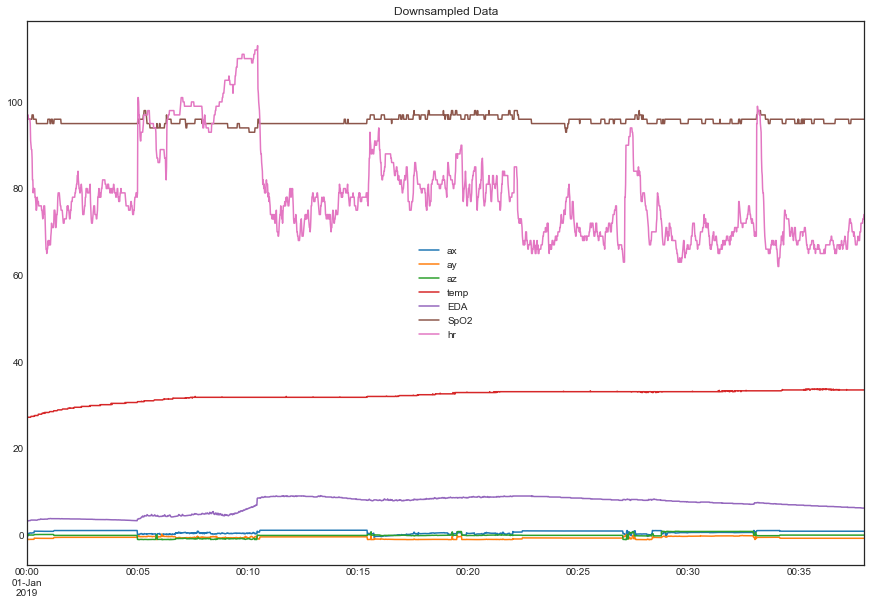

In [28]:
# Not needed, but for consistency with df_option1
df_option2.index = pd.to_datetime(df_option2.index.to_timestamp())

df_option2.plot(figsize=(15, 10))
ax = plt.gca()
ax.set_title('Downsampled Data')
plt.show()

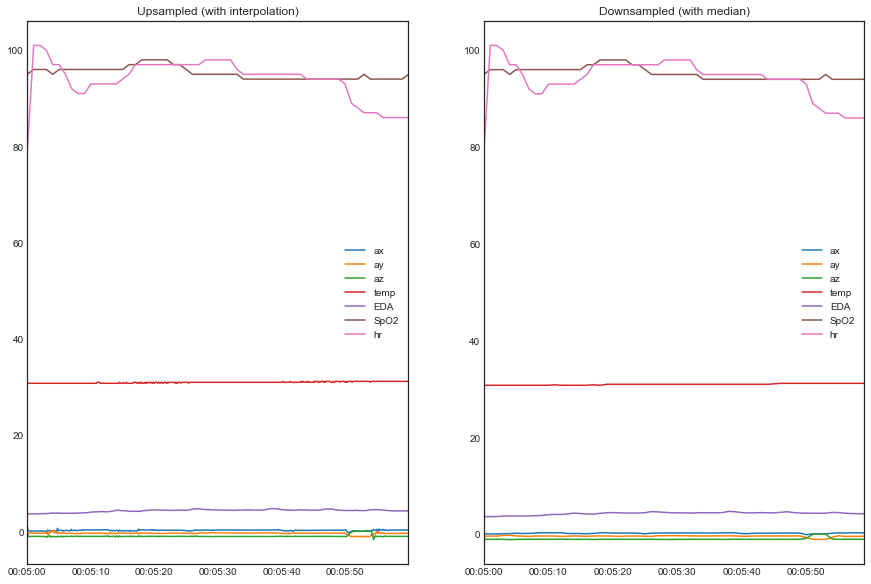

In [29]:
# Let's zoom into a 1-second time window and compare the plots

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
start_time = '2019-01-01 00:05'
end_time = '2019-01-01 00:06'

df_option1[(df_option1.index >= start_time) & (df_option1.index < end_time)].plot(ax=ax1)
ax1.set_title('Upsampled (with interpolation)')
df_option2[(df_option2.index >= start_time) & (df_option2.index < end_time)].plot(ax=ax2)
ax2.set_title('Downsampled (with median)')
plt.show()

## Statistical Features

- Mean, median, standard deviation
- Quantisation / discretisation
- Correlation
- Auto-correlation

In [30]:
df = df_option1

In [31]:
df.mean() # mean of each column

ax       0.692899
ay      -0.624442
az      -0.079151
temp    32.179924
EDA      7.020280
SpO2    95.587481
hr      78.470389
dtype: float64

In [32]:
df.median() # median is less sensitive to outliers than mean

ax       0.869974
ay      -0.639988
az      -0.080007
temp    32.599957
EDA      7.809991
SpO2    95.249985
hr      76.125383
dtype: float64

In [33]:
df.std() # standard deviation

ax       0.365214
ay       0.259942
az       0.451252
temp     1.336794
EDA      1.876670
SpO2     0.855413
hr      11.066407
dtype: float64

In [34]:
df.max()

ax        1.619993
ay        0.579982
az        1.219979
temp     33.899959
EDA       9.146924
SpO2     97.999969
hr      112.999390
dtype: float64

In [35]:
df.min()

ax      -0.739971
ay      -1.739982
az      -1.679977
temp    27.000064
EDA      3.251014
SpO2    93.000046
hr      62.000168
dtype: float64

In [36]:
df.columns

Index(['ax', 'ay', 'az', 'temp', 'EDA', 'SpO2', 'hr'], dtype='object')

### Discretise into quantiles

Discretisation is useful when there is a lot of noise in the signal.

https://datascience.stackexchange.com/questions/19782/what-is-the-rationale-for-discretization-of-continuous-features-and-when-should

In [37]:
df.ax.values.ravel() # raw values

array([0.44996796, 0.43999268, 0.44996796, ..., 0.87998535, 0.87998535,
       0.87998535])

In [38]:
df['ax_q10'] = pd.qcut(df.ax.values.ravel(), 10, labels=False, duplicates='drop')

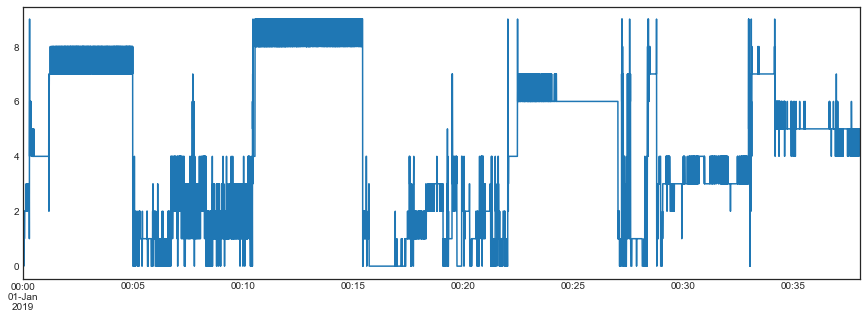

In [39]:
fig, ax = plt.subplots(figsize=(15, 5))
df['ax_q10'].plot(ax=ax)
plt.show()

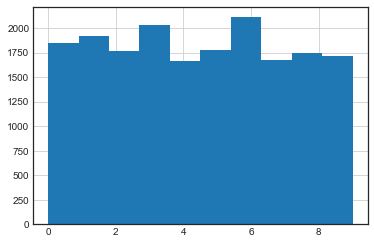

In [40]:
# histogram showing distribution in the 10 levels
# Note: a histogram best applies to discrete variables
df['ax_q10'].hist()

In [41]:
df['ay_q10'] = pd.qcut(df.ay.values.ravel(), 10, labels=False, duplicates='drop')
df['az_q10'] = pd.qcut(df.az.values.ravel(), 10, labels=False, duplicates='drop')

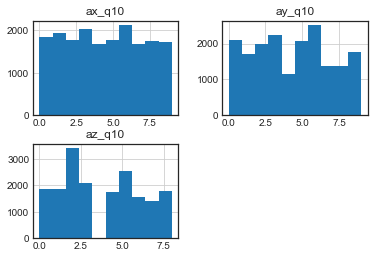

In [42]:
# Plotting multiple histograms
df.loc[:, ['ax_q10', 'ay_q10', 'az_q10']].hist()
plt.show()

### Pair-plot

Pair plots are a combination of scatter plots and histograms. 

They are done for each pair of features (e.g. ax vs. ay)

https://seaborn.pydata.org/generated/seaborn.pairplot.html

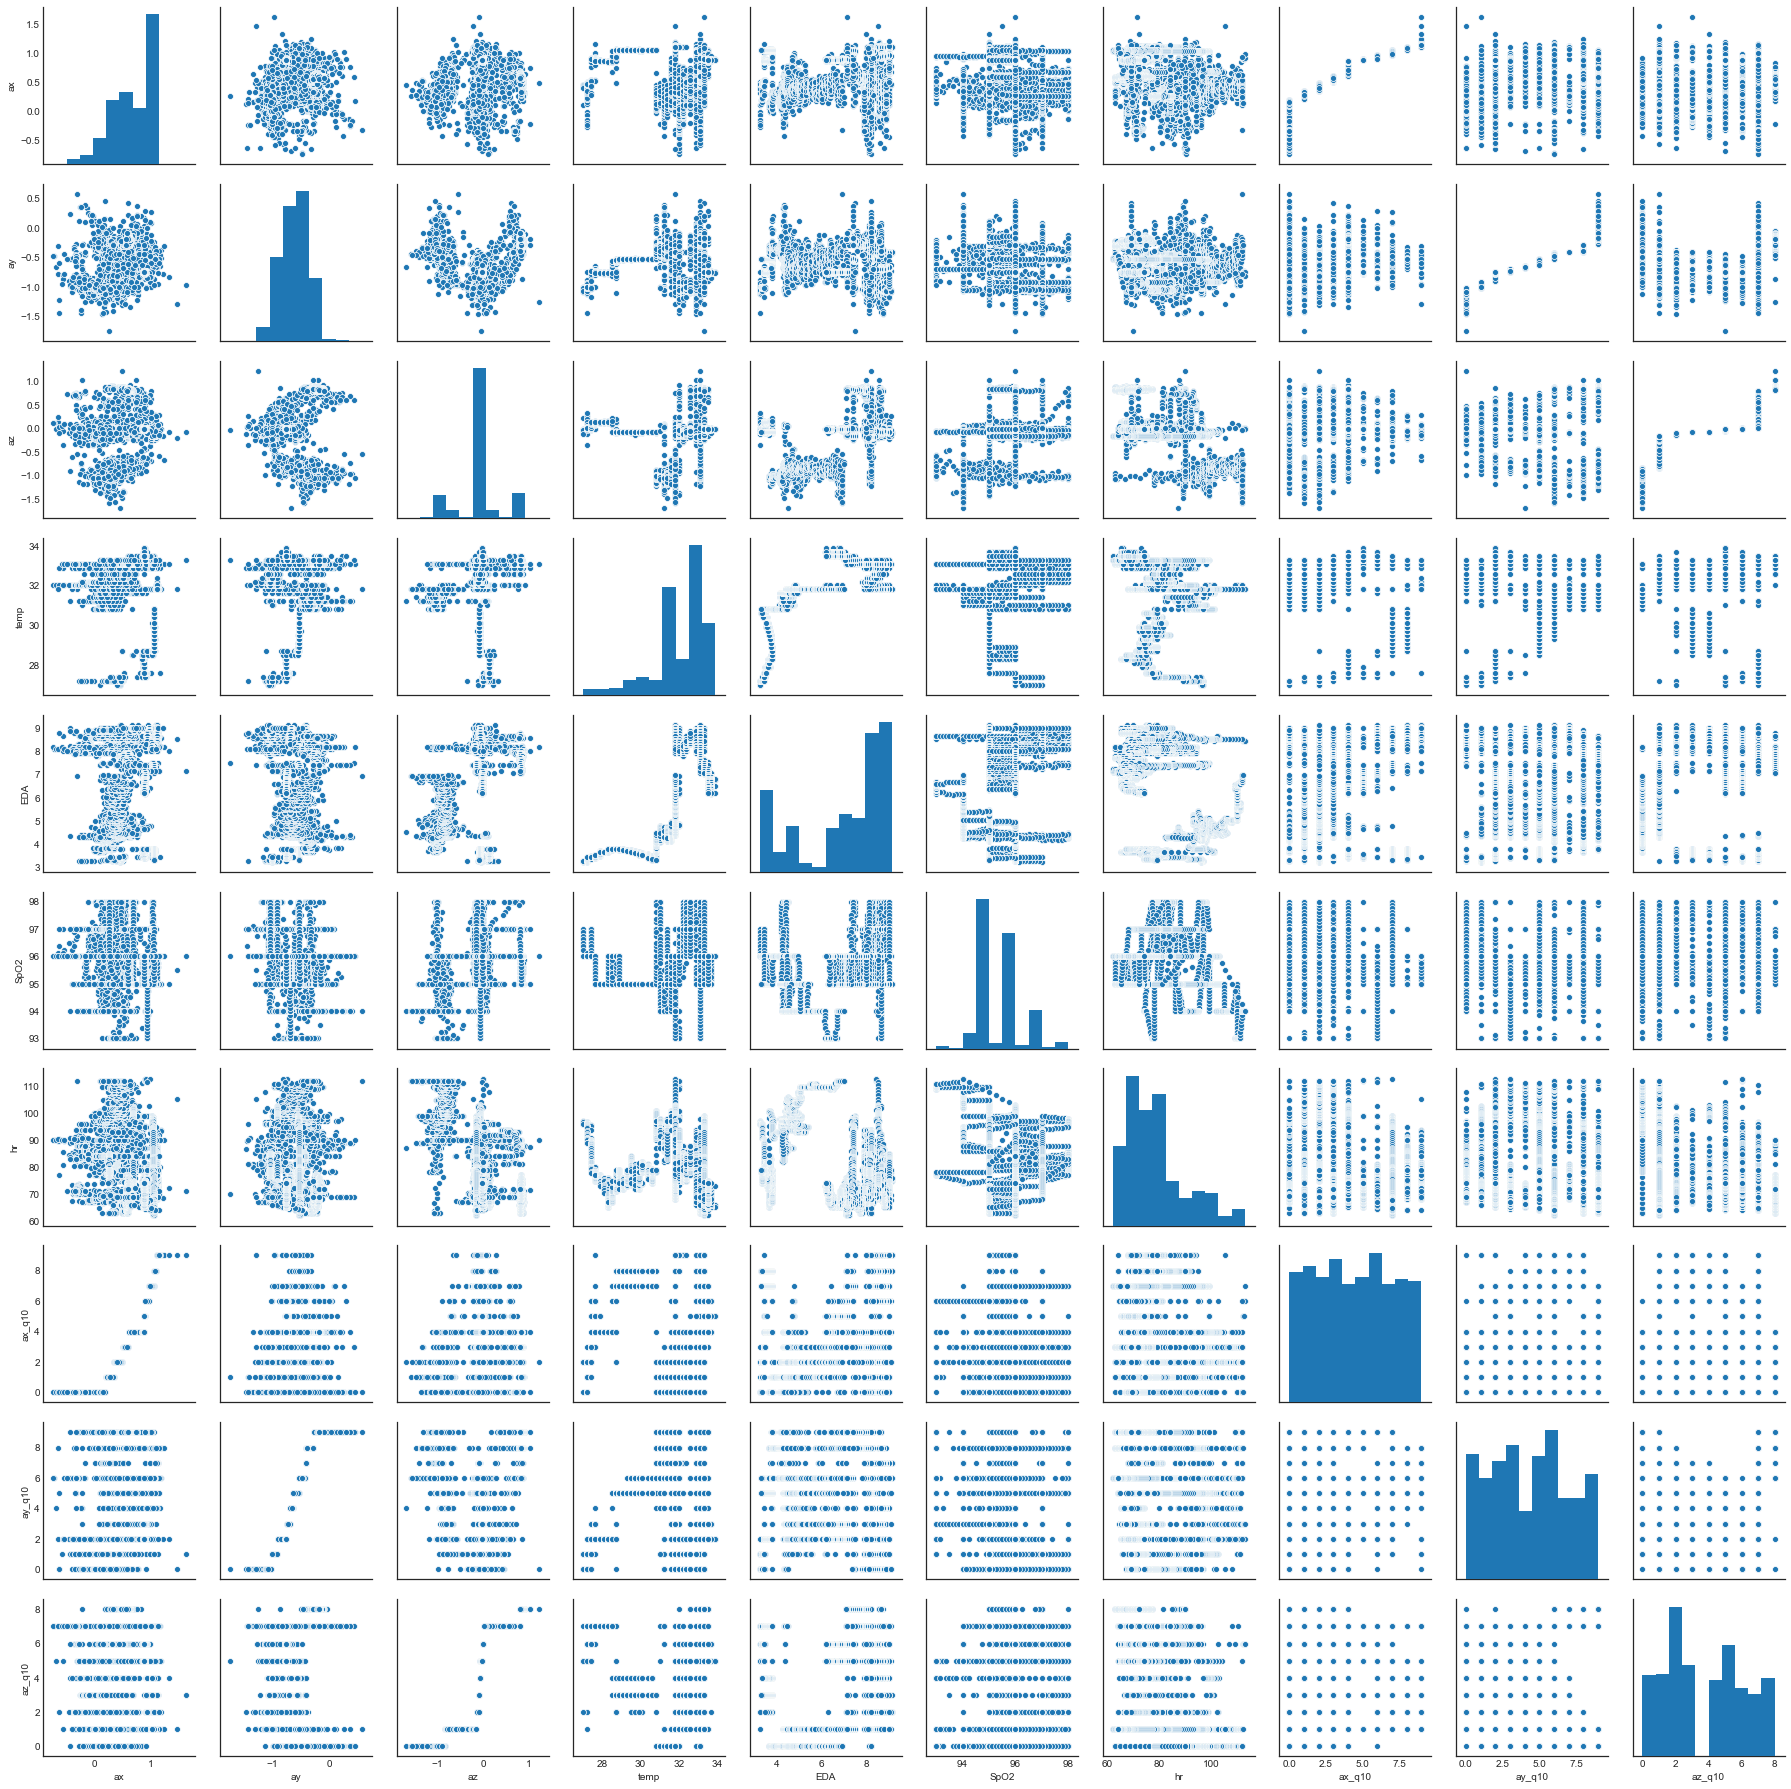

In [43]:
sns.pairplot(df)

### Correlation

Correlations provide a metric to indicate whether two variables are strongly dependent.

https://www.statisticssolutions.com/correlation-pearson-kendall-spearman/

In [44]:
df.corr(method='pearson')

,ax,ay,az,temp,EDA,SpO2,hr,ax_q10,ay_q10,az_q10
ax,1.000000,0.362244,0.170707,-0.110856,-0.018944,-0.298530,-0.473594,0.954295,0.294335,0.011857
ay,0.362244,1.000000,0.159515,-0.077881,-0.186343,-0.479444,-0.081967,0.383866,0.979013,-0.001496
az,0.170707,0.159515,1.000000,0.264251,0.352114,0.246086,-0.661918,0.155289,0.154782,0.844994
temp,-0.110856,-0.077881,0.264251,1.000000,0.695196,0.275015,-0.311503,-0.152813,-0.080247,0.255356
EDA,-0.018944,-0.186343,0.352114,0.695196,1.000000,0.324747,-0.344800,0.042475,-0.168119,0.201379
SpO2,-0.298530,-0.479444,0.246086,0.275015,0.324747,1.000000,-0.113245,-0.324283,-0.447601,0.250082
hr,-0.473594,-0.081967,-0.661918,-0.311503,-0.344800,-0.113245,1.000000,-0.433978,-0.040644,-0.543761
ax_q10,0.954295,0.383866,0.155289,-0.152813,0.042475,-0.324283,-0.433978,1.000000,0.328862,-0.069306
ay_q10,0.294335,0.979013,0.154782,-0.080247,-0.168119,-0.447601,-0.040644,0.328862,1.000000,-0.025101
az_q10,0.011857,-0.001496,0.844994,0.255356,0.201379,0.250082,-0.543761,-0.069306,-0.025101,1.000000


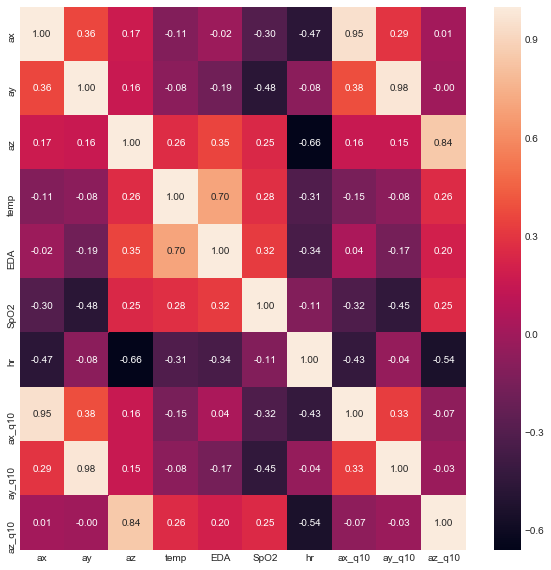

In [45]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(method='pearson'), annot=True, fmt='.2f')
plt.show()

### Auto-correlation

Runs correlation on progressive longer time steps (lags)

https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

The Pearson’s correlation coefficient is a number between -1 and 1 that describes a negative or positive correlation respectively. A value of zero indicates no correlation.

We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.

Confidence intervals are drawn as a cone. By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke.

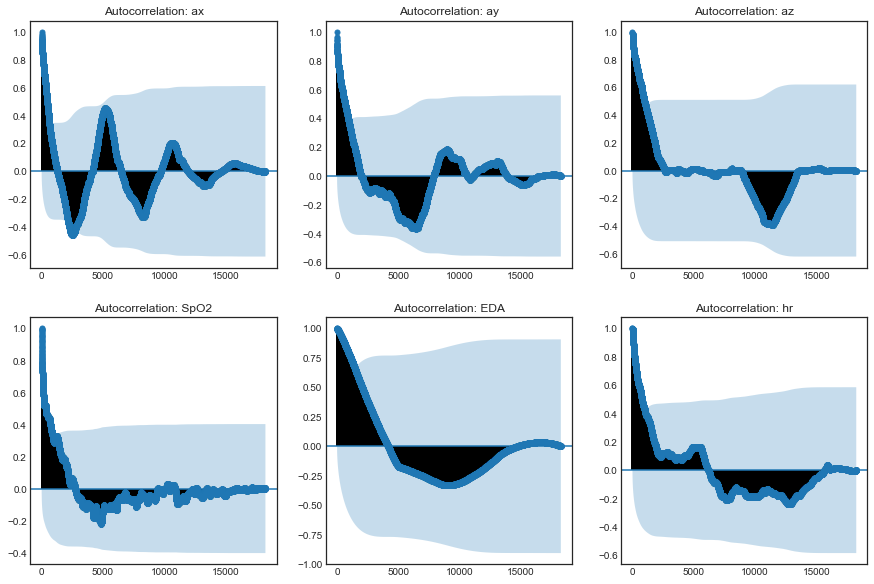

In [46]:
columns = ['ax', 'ay', 'az', 'SpO2', 'EDA', 'hr']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for ax, c in zip(axes, columns):
    plot_acf(df[c], ax=ax)
    ax.set_title(f'Autocorrelation: {c}')

plt.show()

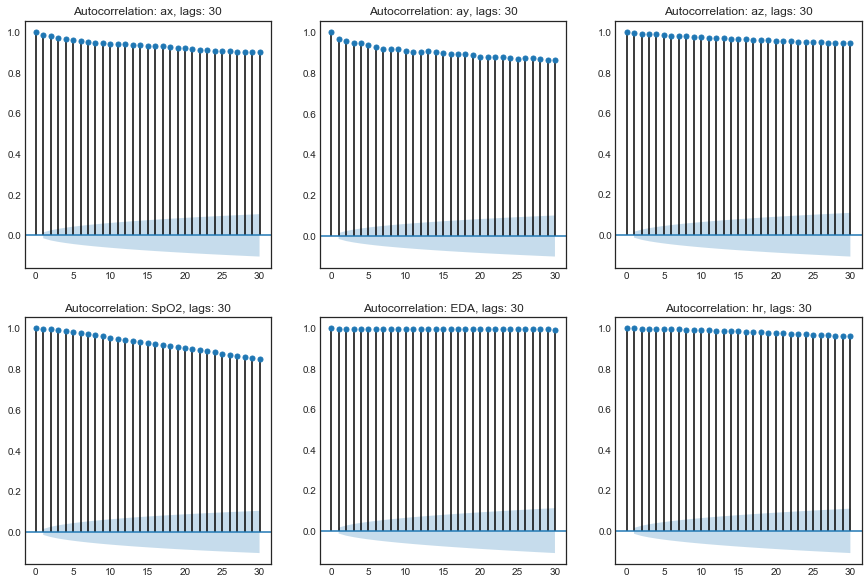

In [47]:
lags = 30

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()
for ax, c in zip(axes, columns):
    plot_acf(df[c], ax=ax, lags=lags)
    ax.set_title(f'Autocorrelation: {c}, lags: {lags}')

plt.show()

## Spectal Features

- FFT: https://ipython-books.github.io/101-analyzing-the-frequency-components-of-a-signal-with-a-fast-fourier-transform/